# Predicting the next word

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Softmax
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


## Getting data

In [2]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 136MB/s]


In [3]:
SONNETS_FILE = 'sonnets.txt'

with open(SONNETS_FILE, 'r') as f:
  corpus = f.read().lower().split('\n')

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## Tokenizing the text

In [6]:
# Instantiate a Tokenizer class
tokenizer = Tokenizer()

# Fit the tokenizer on the text
tokenizer.fit_on_texts(corpus)

# Get the total number of vocabulary words
total_words = len(tokenizer.word_index) + 1

## Generating n_grams

In [19]:
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences
    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []

    for line in corpus:
      sequence = tokenizer.texts_to_sequences([line])[0]
      for i in range(1, len(sequence)):
        n_gram_seq = sequence[:i+1]
        input_sequences.append(n_gram_seq)

    return input_sequences

In [21]:
# Test the function with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [22]:
# Test the function with a bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]

In [23]:
input_sequences = n_gram_seqs(corpus, tokenizer)
max_sequence_len = max([len(seq) for seq in input_sequences])
print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


## Padding the sequences

In [24]:
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length
    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences
    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen, padding='pre')

    return padded_sequences

In [27]:
# Test the function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]], dtype=int32)

In [28]:
# Test the function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)

In [29]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


## Splitting the data into features and labels

In [30]:
def features_and_labels(input_sequences, total_words):
    """
    Generates features and labels from n-grams
    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size
    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, total_words)

    return features, one_hot_labels

In [31]:
# Test the function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,   0,  34],
       [  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213]], dtype=int32)

In [32]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


## Creating a model

In [34]:
def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model
    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences
    Returns:
        model (tf.keras Model): the text generator model
    """
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words))

    model.compile(
        'adam',
        loss = tf.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

In [35]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 20s 23ms/step - loss: 6.8791 - accuracy: 0.0233
Epoch 2/50
484/484 [==============================] - 5s 11ms/step - loss: 6.4265 - accuracy: 0.0334
Epoch 3/50
484/484 [==============================] - 4s 8ms/step - loss: 6.1807 - accuracy: 0.0424
Epoch 4/50
484/484 [==============================] - 5s 10ms/step - loss: 5.9165 - accuracy: 0.0524
Epoch 5/50
484/484 [==============================] - 4s 8ms/step - loss: 5.6123 - accuracy: 0.0616
Epoch 6/50
484/484 [==============================] - 4s 9ms/step - loss: 5.2562 - accuracy: 0.0772
Epoch 7/50
484/484 [==============================] - 9s 18ms/step - loss: 4.8512 - accuracy: 0.0980
Epoch 8/50
484/484 [==============================] - 7s 15ms/step - loss: 4.4206 - accuracy: 0.1319
Epoch 9/50
484/484 [==============================] - 5s 11ms/step - loss: 3.9799 - accuracy: 0.1897
Epoch 10/50
484/484 [==============================] - 4s 8ms/step - loss: 3.5574 - accuracy:

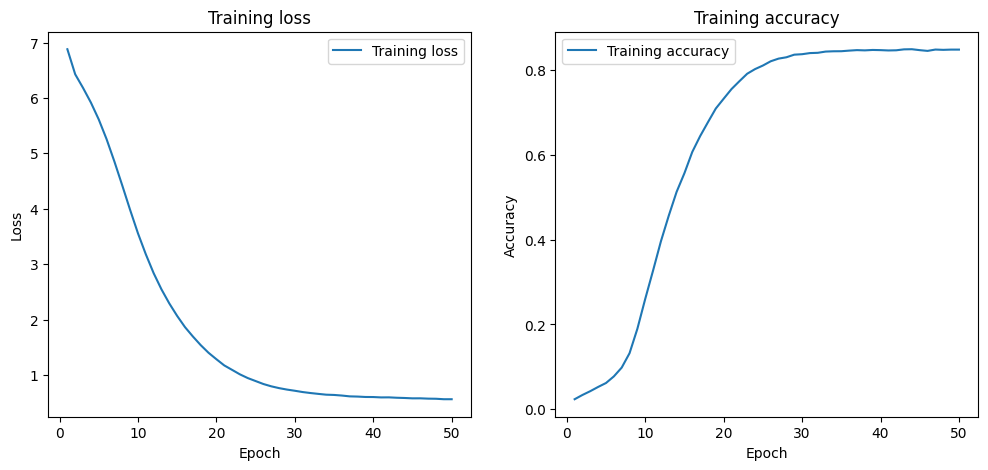

In [37]:
from math import ceil

def plot_params(params: list[str]=[]):
  num_params = len(params)
  num_rows = ceil(num_params/2)
  epochs = [epoch for epoch in range(1, len(history.history[params[0]])+1)]
  plt.figure(figsize=(12, 5*num_rows))
  for i in range(0, num_params):
    s = plt.subplot(num_rows, 2, i+1)
    par = params[i]
    s.plot(epochs, history.history[par], label=f'Training {par}')
    s.set_xlabel('Epoch')
    s.set_ylabel(par.capitalize())
    s.set_title(f'Training {par}')
    s.legend()

plot_params(['loss', 'accuracy'])

## Predicting next words

In [42]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
p_model = Sequential()
p_model.add(model)
p_model.add(Softmax())

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], max_sequence_len-1, padding='pre')
  prediction = p_model.predict(token_list, verbose=0)
  prediction = np.argmax(prediction)
  output_word = tokenizer.index_word[prediction]
  seed_text += ' ' + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope the eye of wrongs thee wrong so short a day is bent your moan and night with all of woe is woe prove woe woe woe shall go prove thee ' blow on ill lie is thee the fair well hath shown held held none dumb you dumb so behavior so hell true wrong will it dead the best wear time held held held seen so heart ' knows it so show it grace my name your heart hath stand behold the worst of my verse can sit time's state ' back thy ill die well youthful chest show too
